# NBA MVP Prediction (Basketball Reference)

### *Predicting the league's most valuable player using ML regression models and observing the impact of advanced statistics in the modern era. Stats pulled from [Basketball Reference](https://www.basketball-reference.com/) for 2001-2023 seasons.*

<img src="https://i.redd.it/i3xdxgxxtzs81.jpg" width="650"/>


# Table of Contents

**1. [Introduction](#Introduction)**

**2. [Importing packages](#Importing-packages)**

**3. [Pre-processing data](#Opening-and-processing-the-data)**

**4. [Modeling 2022-23 MVP](#Modeling-2021-22)**

**5. [Previous seasons](#Old-seasons)**

**6. [Variable Analysis - SHAP](#Variable-Analysis---SHAP)**

**7. [Conclusion](#Conclusion)**


## Introduction

Since the creation of the 3-point line, the evolution of the NBA game has evolved expeditously. So much so that 





## Importing packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [1]:
# Defining seasons and regression models
seasons = ['2022-23','2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07'] 
           
models = ['SVM','Elastic Net','Random Forest','AdaBoost','Gradient Boosting','LGBM']

# Path to local folder
path_data = r'C:\Users\migoc\DATA\JUPYTER WORK\01 DATA PROJECTS\NBA MVP Prediction - Miguel'

sep = r'/'

## Opening and processing the data

In [14]:
def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    advanceds = pd.DataFrame()
    standings = pd.DataFrame()

    for season in seasons:
        pergame = pd.read_csv(path_data+sep+'Data'+sep+season+' Per Game.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Data'+sep+season+' Total.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Data'+sep+season+' Advanced.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Data'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season
        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanceds = pd.concat([advanceds,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)

    return per_game, totals, advanceds, standings

In [30]:
def treat_data(per_game, totals, advanced, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    advanced = advanced.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)
    
    cols = ['Player','Season','Pos','Age','Tm','G','GS']
    
    # Identifying the variables
    for column in per_game.columns:
        if column not in cols:
            new_column = column+'_PERGAME'
            per_game = per_game.rename(columns={column:new_column})
    for column in totals.columns:
        if column not in cols:
            new_column = column+'_TOTAL'
            totals = totals.rename(columns={column:new_column})
    for column in advanced.columns:
        if column not in cols:
            new_column = column+'_ADVANCED'
            advanced = advanced.rename(columns={column:new_column})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    mvps = pd.read_csv(path_data+sep+'Data'+sep+'MVPs.csv',sep=',', decimal='.')
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    
    # Removing duplicate lines from traded players
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)
    
    # Filtering the data
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_ADVANCED']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award
        
    dataf = dataf.drop(['Tm','Team','Record'], axis=1)
    
    return dataf

In [31]:
per_game, totals, advanceds, standings = get_data(seasons)

In [32]:
data = treat_data(per_game, totals, advanceds, standings, seasons)

In [33]:
data

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share
0,Bam Adebayo,25,75,75,34.6,8.0,14.9,0.540,0.0,0.2,...,240,88,61,187,208,1529,13.0,0.536585,0,0.000
1,Giannis Antetokounmpo,28,63,63,32.1,11.2,20.3,0.553,0.7,2.7,...,359,52,51,246,197,1959,1.0,0.707317,3,0.606
2,Deandre Ayton,24,67,67,30.4,7.8,13.2,0.589,0.1,0.4,...,115,37,53,120,190,1203,10.0,0.548780,0,0.000
3,Desmond Bane,24,58,58,31.7,7.8,16.2,0.479,2.9,7.0,...,254,56,22,126,150,1247,6.0,0.621951,0,0.000
4,Devin Booker,26,53,53,34.6,9.9,20.1,0.494,2.1,6.0,...,293,51,18,145,159,1471,10.0,0.548780,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,Tony Parker,24,77,77,32.5,7.4,14.2,0.520,0.2,0.5,...,420,82,6,191,137,1429,3.0,0.707317,15T,0.001
431,Chris Paul,21,64,64,36.8,6.0,13.6,0.437,0.8,2.2,...,569,118,3,161,154,1104,0.0,0.000000,0,0.000
432,Amar'e Stoudemire,24,82,78,32.8,7.4,12.9,0.575,0.0,0.0,...,84,78,110,232,295,1671,2.0,0.743902,14,0.002
433,Dwyane Wade,25,51,50,37.9,9.3,18.9,0.491,0.4,1.5,...,384,107,62,216,117,1397,11.0,0.536585,12T,0.002


In [34]:
data.columns # Variables

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_ADVANCED',
       'TS%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'DRB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED',
       'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED', 'OWS_ADVANCED',
       'DWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'OBPM_ADVANCED',
       'DBPM_ADVANCED', 'BPM_ADVANCED', 'VORP_ADVANCED', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 

In [35]:
data['Season'].value_counts() # Number of players in the data per season

Season
2006-07    29
2007-08    29
2016-17    29
2011-12    29
2020-21    28
2010-11    28
2013-14    27
2009-10    27
2022-23    27
2021-22    25
2018-19    25
2012-13    24
2015-16    24
2014-15    22
2008-09    21
2019-20    21
2017-18    20
Name: count, dtype: int64

## Modeling 2022-23

In [59]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [60]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model_name in models:
            # Creating instance for each model
            if model_name=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model_name=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model_name=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model_name=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model_name=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model_name=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            model.fit(scaled_X_train, y_train)
            
            pickle.dump(obj=model,file=open((path_data+sep+'Models'+sep+model_name+'.dat'),'wb'))
            
            y_pred = model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model_name, season)

            temp = initial_results.copy()
            temp['Predicted MVP Share '+model_name] = pd.Series(y_pred).values

            results_sorted = temp.sort_values(by='Predicted MVP Share '+model_name,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model_name] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [61]:
def median_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        median_df = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,median_df], ignore_index=True)
    return final_metrics

In [62]:
final_results, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = median_metrics(metrics)
final_metrics

,Model,RMSE,R²
0,SVM,0.106,0.796
1,Elastic Net,0.143,0.630
2,Random Forest,0.142,0.636
3,AdaBoost,0.123,0.726
4,Gradient Boosting,0.111,0.778
5,LGBM,0.103,0.807


In [64]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Votes Share']
        for model_name in models:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+model_name, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+model_name] = temp2['Player']
                rank['MVP Share '+model_name] = round(temp2['Predicted MVP Share '+model_name],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)
    
    return rank_final

In [65]:
rank_final = create_rank(final_results, 3)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank Elastic Net,MVP Share Elastic Net,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,Season
0,Joel Embiid,0.915,Nikola Jokić,0.641,Nikola Jokić,0.528,Joel Embiid,0.558,Nikola Jokić,0.675,Joel Embiid,0.754,Joel Embiid,0.838,2022-23
1,Nikola Jokić,0.674,Joel Embiid,0.611,Joel Embiid,0.439,Nikola Jokić,0.518,Joel Embiid,0.550,Nikola Jokić,0.613,Nikola Jokić,0.709,2022-23
2,Giannis Antetokounmpo,0.606,Giannis Antetokounmpo,0.603,Giannis Antetokounmpo,0.389,Luka Dončić,0.466,Luka Dončić,0.359,Giannis Antetokounmpo,0.558,Giannis Antetokounmpo,0.443,2022-23


##  Old seasons

In [67]:
def old_seasons(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing 
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model_name in models:
            
            if model_name=='Elastic Net':
                continue
            
            # Opening the models already created          
            model = pickle.load(open((path_data+sep+'Models'+sep+model_name+'.dat'),'rb'))
                
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model_name, season)

            temp = initial_results.copy()
            temp['Predicted MVP Share '+model_name] = pd.Series(y_pred).values

            results_sorted = temp.sort_values(by='Predicted MVP Share '+model_name,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model_name] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

In [71]:
# predicting all 17 seasons from 2007-2023
final_results, metrics = old_seasons(data, seasons, models, 17)
final_metrics = median_metrics(metrics)
final_metrics

,Model,RMSE,R²
0,SVM,0.132,0.660
1,Random Forest,0.135,0.648
2,AdaBoost,0.136,0.641
3,Gradient Boosting,0.125,0.701
4,LGBM,0.129,0.677


In [72]:
rank_final = create_rank(final_results, 1)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,Season
0,Joel Embiid,0.915,Nikola Jokić,0.641,Joel Embiid,0.625,Nikola Jokić,0.704,Joel Embiid,0.754,Joel Embiid,0.838,2022-23
1,Nikola Jokić,0.875,Nikola Jokić,0.779,Giannis Antetokounmpo,0.667,Nikola Jokić,0.654,Nikola Jokić,0.575,Nikola Jokić,0.670,2021-22
2,Nikola Jokić,0.961,Nikola Jokić,0.730,Nikola Jokić,0.730,Nikola Jokić,0.674,Nikola Jokić,0.680,Nikola Jokić,0.704,2020-21
3,Giannis Antetokounmpo,0.952,Giannis Antetokounmpo,0.641,James Harden,0.695,Giannis Antetokounmpo,0.583,Giannis Antetokounmpo,0.894,Giannis Antetokounmpo,0.794,2019-20
4,Giannis Antetokounmpo,0.932,Giannis Antetokounmpo,0.758,James Harden,0.744,Giannis Antetokounmpo,0.767,James Harden,0.870,Giannis Antetokounmpo,0.872,2018-19
5,James Harden,0.955,James Harden,0.718,James Harden,0.669,James Harden,0.814,James Harden,0.952,James Harden,0.817,2017-18
6,Russell Westbrook,0.879,LeBron James,0.514,Russell Westbrook,0.477,Kawhi Leonard,0.713,James Harden,0.588,Kawhi Leonard,0.695,2016-17
7,Stephen Curry,1.000,LeBron James,0.609,Stephen Curry,0.725,Stephen Curry,0.847,Stephen Curry,0.918,Stephen Curry,0.932,2015-16
8,Stephen Curry,0.922,Stephen Curry,0.493,Stephen Curry,0.602,Stephen Curry,0.618,Stephen Curry,0.690,Anthony Davis,0.614,2014-15
9,Kevin Durant,0.986,Kevin Durant,0.830,Kevin Durant,0.616,Kevin Durant,0.697,Kevin Durant,0.805,Kevin Durant,0.966,2013-14


## Variable Analysis - SHAP

SHAP values help you in:

- **Global model interpretability**: creating a guideline for statistics that increase a player's chances of winning the MVP award.



- **Local interpretability**: allows for an individual case analysis.
    - a player can follow the guidelines and still not win the MVP. By analyzing the individual's performance (features), you can observe which metrics led to the "No-MVP" result.

In [95]:
data_test = data[data['Season']=='2021-22']
X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
feature_names = list(X_test.columns)

scaler = StandardScaler()
scaler.fit(X_test)
scaled_X_test = scaler.transform(X_test)

In [96]:
scaled_X_test = pd.DataFrame(scaled_X_test)

In [97]:
svm_model = pickle.load(open(file=path_data+sep+'Models'+sep+'SVM.dat',mode='rb'))
explainer = shap.Explainer(svm_model.predict, scaled_X_test)
shap_values = explainer(scaled_X_test)

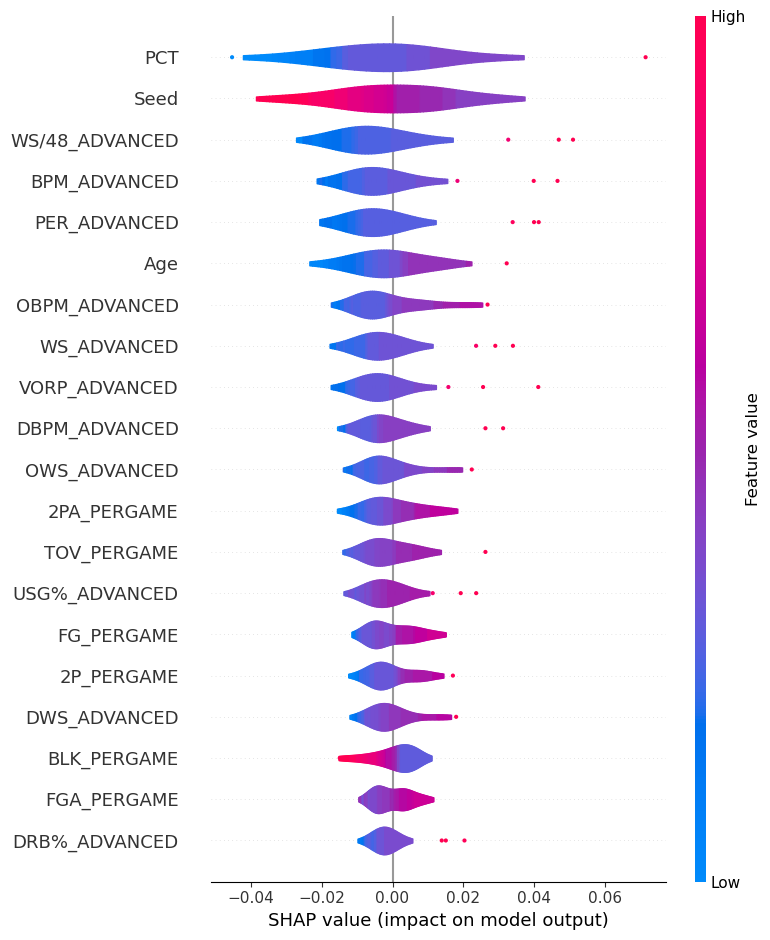

In [90]:
shap.summary_plot(shap_values, X_test,feature_names, plot_type='violin') # Top 20 variables

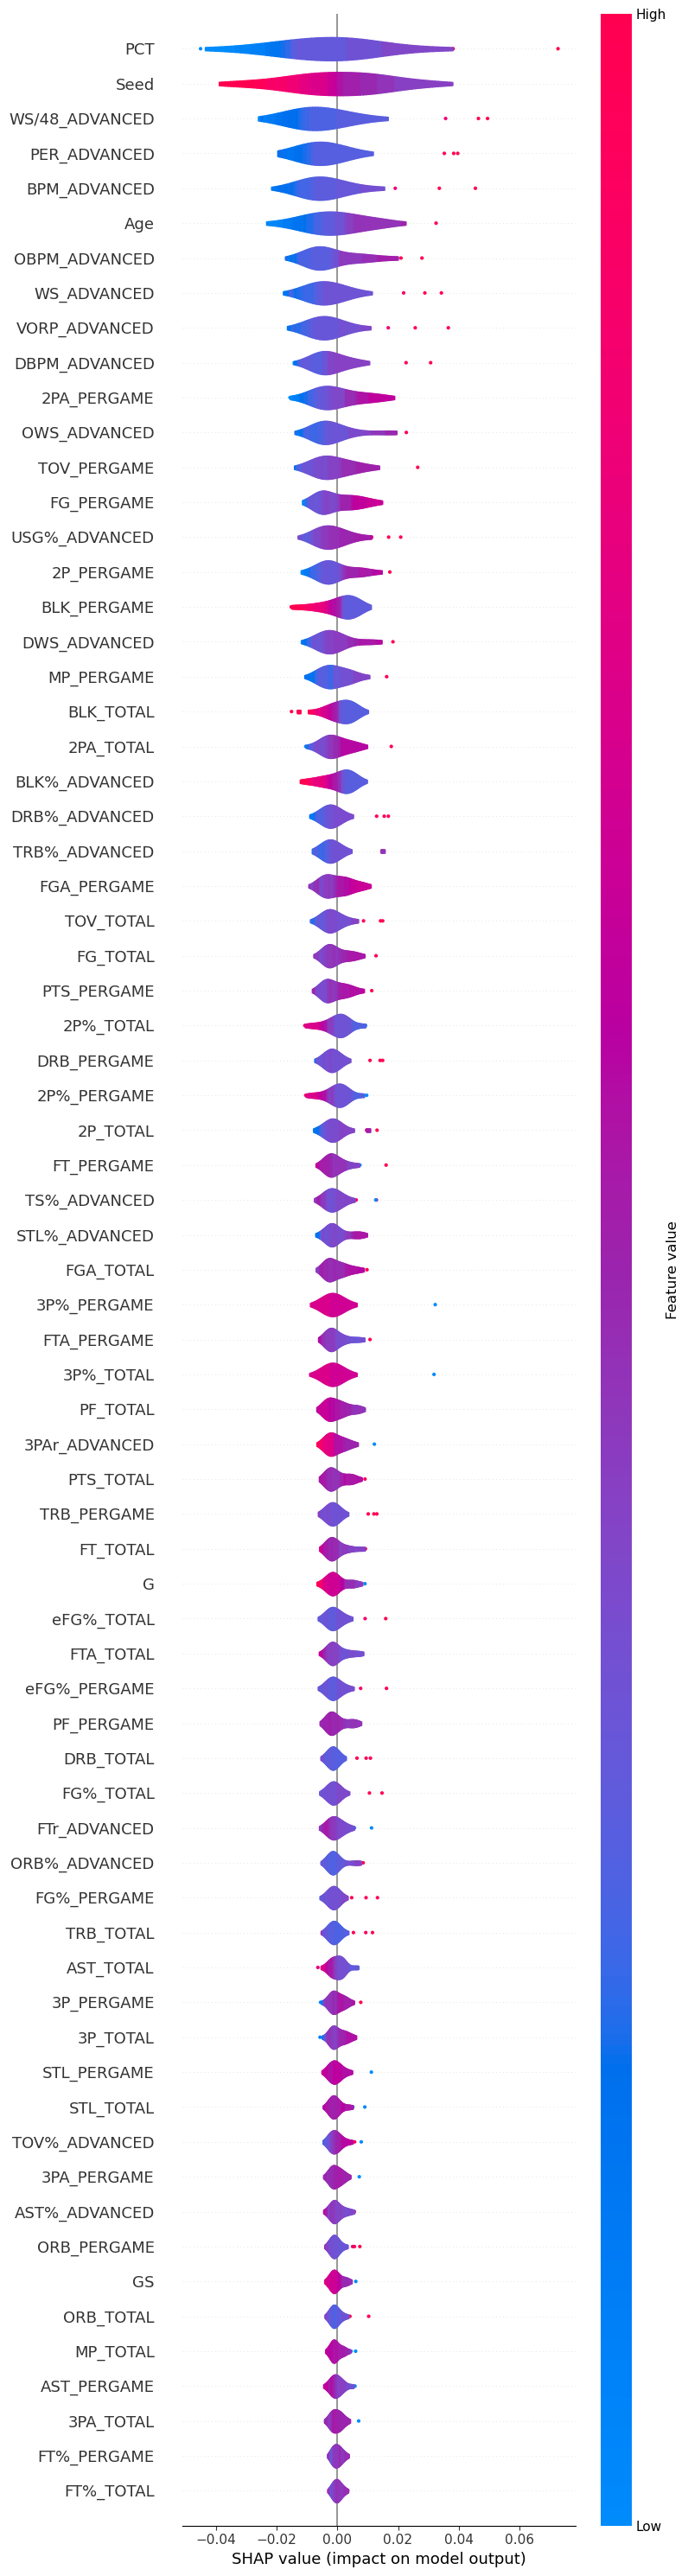

In [99]:
shap.summary_plot(shap_values, X_test, feature_names, plot_type='violin', max_display=len(feature_names)) # All variables

## Conclusion

Takeaways
What can you do to improve the model?


- SHAP: https://towardsdatascience.com/a-complete-shap-tutorial-how-to-explain-any-black-box-ml-model-in-python-7538d11fae94
- Model: https://towardsdatascience.com/predicting-the-nba-mvp-with-machine-learning-c3e5b755f42e